# Sesión 15: Segmentación K-Means (Caso Resuelto)

## Caso:
En una entidad bancaria existen varios canales de comunicación tales como: ATM, Oficinas, Banca Telefónica (IVR), Banca por internet, Banca Móvil, entre otros.
Sin embargo, al realizar las comunicaciones de ofertas a los clientes de dicho banco, el cliente recibe diversas ofertas de distintos canales sin saber si les da importancia o no, por lo que ya interviene un gasto por parte de la entidad, ya que, realiza alianzas estratégicas de campaña.

**Dato adicional:**

* El dataset consta de 40K clientes
* El dataset incluye información de 12 meses de historia
* Consta de 11 canales de comunicación:
    -	Agente plus
    -	Banca express
    -	Saldo express
    -	Banca móvil
    -	Banca internet
    -	IVR
    -	SBT
    -	Ventanilla
    -	ATM
    -	POS TD
    -	POS TC



Se requiere identificar cuál sería el medio de comunicación preferido para los clientes y así enviarles ofertas, promociones, recordatorios, etc. más direccionadas.

## 1. Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2. Extracción Base de datos

In [ ]:
dataFrame = pd.read_csv("data/01dataBaseMulti.txt",delimiter='|')
dataFrame.head()

In [ ]:
print("Número de filas: " + str(dataFrame.shape[0]))
print("Número de columnas: " + str(dataFrame.shape[1]))

In [ ]:
dataFrame.info()

## 3. Metodología

**3.1 Análisis Previo (objetivo)**<br>
**3.2 Exploración (descriptivo, grafico barras,cajas)**<br>
**3.3 Transformación (standarización,cajas)**<br>
**3.4 Outliers (analisis y eliminación de outliers)**<br>
**3.5 Dimensionamiento (PCA)**<br>
**3.6 Modelamiento**<br>
**3.7 Evaluación**<br>
**3.8 Perfilamiento**<br>
**3.9 Visualización**

In [ ]:
# Variables objetivo de estudio (K-means solamente permite usar variables cuantitativas):
channelName = ['trxAplus', 'trxBcaex', 'trxSalex', 'trxBm', 'trxBxi', 'trxIvr', 'trxSbt', 'trxVent',
               'trxAtm','trxPostc', 'trxPostd']

### 3.1 Análisis Negocio

El dataset ya se encuentra trabajado a nivel de cliente con sus respectivas variables, se consideraron filtros de criterios de autoasignados, distribución histórica de transacciones, etc. 

### 3.2 Exploración

In [ ]:
print(dataFrame[channelName].describe())

In [ ]:
dataFrame[channelName].hist(bins = 50, figsize=(20,15))
plt.show()

In [ ]:
# Gráfico de cajas por variable en estudio:
for columnName in channelName:
    plt.title(columnName)  
    plt.boxplot(dataFrame[columnName], 0, 'gD')    
    plt.show()

### 3.3 Transformación (normalización estándar)

In [ ]:
# ------------------------------
# Creamos el objeto para escalar
# ------------------------------
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# ************
# Lo aplicamos
# ************
for columnName in channelName:
    dataFrame[columnName] = scaler.fit_transform(dataFrame[columnName].values.reshape(-1, 1))

#for columnName in columName:
#    dataFrame[columnName] = dataFrame[columnName]/dataFrame['trx']

In [ ]:
dataFrame[channelName].head()

### 3.4 Outliers

In [ ]:
# Cálculo de intervalo del diagrama de cajas - Método de Rango Intercuartílico --- usando gráficos de caja

#def calculateNumOutliars(serie):
#  Q01 = serie.quantile(0.25)
#  Q03 = serie.quantile(0.75)
#  IQR = Q03 - Q01
#  a = (serie < (Q01 - 1.5 * IQR)) | (serie > (Q03 + 1.5 * IQR))
#  numOutliars = a[a == True].shape[0]
#  return numOutliars

In [ ]:
# Usamos el método de Z-score (considerando se distribuye Normalmente) --- para grandes volúmenes de datos
def calculateNumOutliars(serie):
    mu = serie.mean()
    desv = np.std(serie)
    a = ((serie-mu)/desv < -2) | ((serie-mu)/desv > 2)
    numOutliars = a[a == True].shape[0]
    return a,numOutliars    

In [ ]:
numTotal = dataFrame.shape[0]
for columnName in channelName:
    a,numOutliars = calculateNumOutliars(dataFrame[columnName])
    # Creamos nuevos campos para filtrar los Outliers 
    dataFrame['flg_'+columnName]=a
    print('*'+columnName)
    if numOutliars > 0:
        print("Número de valores outliars: " + str(numOutliars))
        print("Porcentaje: " + str(np.round(numOutliars * 100 / numTotal, 2)) + "%")
    else:
        print("****No hay Outliers")    
    print("\n")

In [ ]:
# ************************
# Extrayendo los Outliers
# ************************
# Luego que cada variable tenga menos del 10% de Outlier, se filtra de manera Multivariada (este filtro podría ser
# considerado como un segmento Heavy)

dataFrame = dataFrame[(dataFrame['flg_trxAplus']==False)&
                      (dataFrame['flg_trxBcaex']==False)&
                      (dataFrame['flg_trxSalex']==False)&
                      (dataFrame['flg_trxBm']==False)&
                      (dataFrame['flg_trxBxi']==False)&
                      (dataFrame['flg_trxIvr']==False)&
                      (dataFrame['flg_trxSbt']==False)&
                      (dataFrame['flg_trxVent']==False)&
                      (dataFrame['flg_trxAtm']==False)&
                      (dataFrame['flg_trxPostc']==False)&
                      (dataFrame['flg_trxPostd']==False)]

print('Cantidad de Registros sin Outliers: '+str(dataFrame.shape[0]))
dataFrame[channelName].head()

### 3.5 Reducción de dimensión (PCA) --- cuando hay demasiadas variables (etapa opcional)

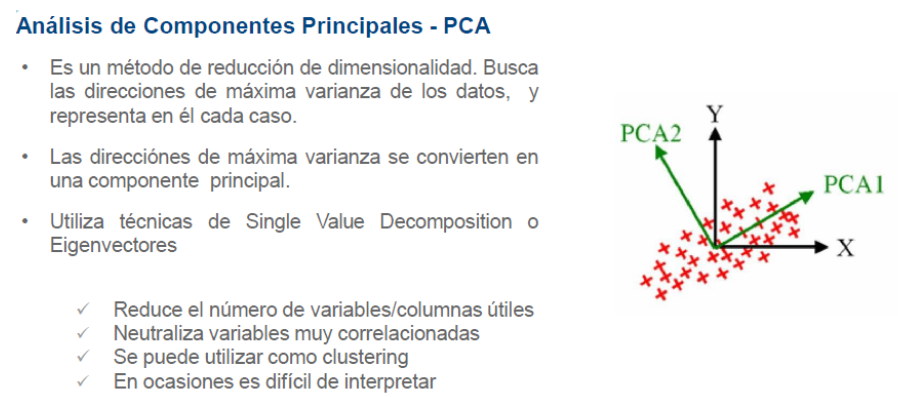

In [ ]:
# Calculamos el máximo número de componentes (Nro variables = Nro máximo de componentes)
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(dataFrame[channelName])
pca.explained_variance_ratio_

In [ ]:
for i in range(len(pca.components_)):
    print('% Var. explicada ('+str(i+1)+' componentes): ', np.cumsum(pca.explained_variance_ratio_)[i]*100)
    
plt.bar(range(1,len(pca.components_)+1),pca.explained_variance_ratio_, alpha=.2,color='0')
plt.plot(range(1,len(pca.components_)+1),np.cumsum(pca.explained_variance_ratio_),alpha=4)
plt.title("Varianza explicada y pareto")
plt.show()

Según el gráfico podemos observar que hay tendencia a que cada componente aporta información relevante, por lo que no existe alguna relación fuerte entre variables

In [ ]:
# Elegimos la componente adecuada:
pcaFin = PCA(n_components=11)
pcaFin.fit(dataFrame[channelName])
pd.DataFrame(pcaFin.components_,columns=channelName)

Confirmamos nuestra evidencia en el gráfico de Pareto, donde: Para cada variable está asignado a cada Componente, Por tanto no existe reducción de dimensiones para nuestro estudio de canales de transacción

### 3.6 Modelamiento

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min 

In [ ]:
# Calculando el número de clúster adecuado:
X = dataFrame[channelName]
X.head()

In [ ]:
# Calculando el número de clúster adecuado:
X = dataFrame[channelName]
score = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i,max_iter=600, algorithm = 'auto')
    kmeans_model = kmeans.fit(X)
    score.append(kmeans_model.inertia_)

In [ ]:
plt.plot(range(1, 20), score, marker='o')
plt.xlabel('Número de Clúster')
plt.ylabel('Score')
plt.title('Elbow method')
plt.show()

No se puede encontrar un número pequeño de clusters (no se ve el codo y se ve una caída lenta). Podemos ver que la cantidad de clústers se encuentra entre 1 a 11 clústers. Vamos a probar el indicador de la silueta.

In [ ]:
from sklearn.metrics import silhouette_score

# Nos fijamos de los indicadores de clustering:

for i in range(2,12): 
    kmeans = KMeans(n_clusters=i,max_iter=600, algorithm = 'auto')
    kmeans_model = kmeans.fit(X)
    cluster = kmeans_model.predict(X)
    print(str(i)+' clústeres:')
    print('Inercia: '+str(kmeans.inertia_))
    print('Silueta: '+str(silhouette_score(X, cluster, metric='euclidean', sample_size = 5000, random_state=123)))

Vemos que entre 2 y 4 clusters podrían ser adecuados, ya que se ve una caída relativamente significativa en el indicador de silueta.

Visualizando los grupos en 2-D para tener alguna noción de como se agrupan, en esta ocasión probaremos distintos par de variables

In [ ]:
# coriendo para 3 clusters
kmeans = KMeans(n_clusters=3,max_iter=600, algorithm = 'auto')
kmeans_model = kmeans.fit(X)
cluster = kmeans_model.predict(X)
    
# graficando para esta cantidad de clusters
fig = plt.figure()
f1 = dataFrame['trxAtm'].values
f2 = dataFrame['trxBm'].values
 
#colores=['red','green','blue','yellow']
colores=['yellow','green','blue']
asignar=[]
for row in cluster:
    asignar.append(colores[row])
    
plt.scatter(f1, f2, c=asignar, marker='*', s=100)
#plt.scatter(centroide[2][:, 0], centroide[2][:, 1], marker='*', c='yellow', s=100)
plt.show()

In [ ]:
fig = plt.figure()
f1 = dataFrame['trxAtm'].values
f2 = dataFrame['trxPostd'].values
 
#colores=['red','green','blue','yellow']
colores=['yellow','green','blue']
asignar=[]
for row in cluster:
    asignar.append(colores[row])
    
plt.scatter(f1, f2, c=asignar, marker='*', s=100)
plt.show()

### 3.7 Evaluación

In [ ]:
numClus = [2,3,4,5]

kmeans = [KMeans(n_clusters=i,max_iter=600, algorithm = 'auto') for i in numClus]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
cluster = [kmeans[i].predict(X) for i in range(len(kmeans))]

In [ ]:
centroide = [kmeans[i].cluster_centers_ for i in range(len(kmeans))]
copy =  pd.DataFrame()

for i in numClus:
    # Distribución de los grupos por clúster:
    copy['cluster'] = cluster[i-2]   #cuidado con la cantidad de clusters
    cantidadGrupo =  pd.DataFrame()
    cantidadGrupo['ctdCliente']=copy.groupby('cluster').size()
    cantidadGrupo['pctCliente']=round(100*cantidadGrupo['ctdCliente']/cantidadGrupo['ctdCliente'].sum(),2)
    
    # gráfico de los grupos según su distribución:
    plt.pie(cantidadGrupo['pctCliente'], labels=cantidadGrupo.index, autopct='%1.1f%%')
    plt.title('Clúster '+str(i))
    plt.legend()
    plt.show()
    print(cantidadGrupo)       
    print('\n')

In [ ]:
numClusFinal = int(input('Ingrese el número de clúster: '))

In [ ]:
dfval = pd.DataFrame(centroide[numClusFinal-2],columns=channelName)
dfval

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
#plt.style.use('ggplot')

dfval.plot.barh()

Con este diagrama de barras podemos nombrar a los clusters de acuerdo a sus características. 

* El primer cluster (0) no tiene características resaltantes de ninguna de las variables, podríamos decir que es el **Segmento Estándar**.
* El segundo cluster (1) resalta en transacciones del canal de banca express, podríamos decir que es el **Segmento Express**.
* El tercer cluster (3) resalta en transacciones del canal ATM y compras con Tarjeta de Débito, podríamos decir que es el **Segmento Ahorro**.